In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

You can use this framework to compute sentence / text embeddings for more than 100 languages. These embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining.

In [1]:
#install  sentence-transformers
!pip install sentence-transformers

     |████████████████████████████████| 85 kB 951 kB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 190 kB 33.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.6 MB 46.4 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125918 sha256=60548126848caa009749487bd39c4ded8a5b07aa438135ded5c4a98e58061284
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently

In [45]:
#check GPU utlization
!nvidia-smi 

Sat Feb 25 14:12:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |  10509MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#import important libraries
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [3]:
import pandas as pd
# Read dataset in dataframe format
data = pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv',memory_map=True)
data.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


In [4]:
#look at dataset columns
data.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [5]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [6]:
#we will take title and plot columns to be ower feature
#drob the rest of features
import gc
df = data[['Title','Plot']]
#delate the data varible to free space in memory
del data
gc.collect()

88

In [7]:

df.dropna(inplace=True) #Drop null values in dataframe
df.drop_duplicates(subset=['Plot'],inplace=True) # Drop Duplicates values 

In [30]:
df

,Title,Plot,doc_len
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...",83
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...",86
2,The Martyred Presidents,"The film, just over a minute long, is composed...",76
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...,153
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...,140
...,...,...,...
34880,Sivas,The film follows an eleven-year-old boy named ...,384
34882,Çalgı Çengi İkimiz,"Two musicians, Salih and Gürkan, described the...",11
34883,Olanlar Oldu,"Zafer, a sailor living with his mother Döndü i...",67
34884,Non-Transferable,The film centres around a young woman named Am...,193


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


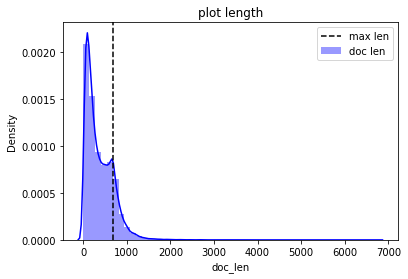

In [8]:
#plot Hist to show the length of documents
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [52]:
#We now have all the features we'd like to concatenate in one column
df = df['Title'] + '. ' + df['Plot']

In [53]:
df=pd.DataFrame(df,columns=['text'])

**visualize the data to see more frequent words**

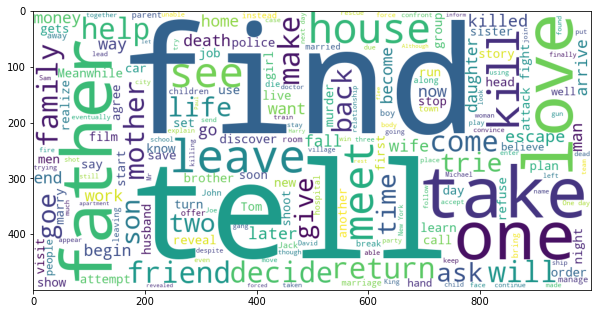

In [55]:
plt.figure(figsize=(10,6))
from wordcloud import WordCloud, STOPWORDS
word_cloud = ""
for row in df['text']:
    for word in row:
        word_cloud += " ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

**Query Generation**

We now have movies text, but no queries, and we need (query, movies) pairs to fine-tune a model. To do this they fine-tuned a BART model on MS MARCO, then used it to generate the queries.

We don't need to fine-tune the BART model as there are already plenty of models that are readily available and have been fine-tuned on the exact same (MS MARCO) dataset, so we will initialize one of these using the HuggingFace transformers library.

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from  torch.cuda import is_available

device = 'cuda' if is_available() else 'cpu'

# import model to convert documents to query
model_name = 'doc2query/all-t5-base-v1'

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(
    model_name
).to(device)

Now we begin generating queries, the Movies article didn't state if they produce a certain number of queries for each movie, we will assume they generated three queries per movie.

In [ ]:
from tqdm.auto import tqdm

batch_size = 128  # larger batch size == faster processing
num_queries = 3  # number of queries to generate for each movie
pairs = []
movi_batch = []
with open('generated_queries_last.tsv', 'w') as fOut:

    for ep in tqdm(df):
        # remove tab + newline characters if present
        movi_batch.append(ep.replace('\t', ' ').replace('\n', ' '))

        # we encode in batches
        if len(movi_batch) == batch_size:
            # tokenize the passage
            inputs = tokenizer(
                movi_batch,
                truncation=True,
                padding=True,
                max_length=256,
                return_tensors='pt'
            )

            # generate three queries per movie
            outputs = model.generate(
                input_ids=inputs['input_ids'].to(device),
                attention_mask=inputs['attention_mask'].to(device),
                max_length=64,
                do_sample=True,
                top_p=0.95,
                num_return_sequences=num_queries
            )

            # decode query to human readable text
            decoded_output = tokenizer.batch_decode(
                outputs,
                skip_special_tokens=True
            )

            # loop through to pair query and movies
            #Store query and movie document in tsv file
            #to use it later and free space in memory
            for i, query in enumerate(decoded_output):
                query = query.replace('\t', ' ').replace('\n', ' ')  # remove newline + tabs
                mv_idx = int(i/num_queries)  # get index of episode to match query
                fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), movi_batch[mv_idx].replace("\t", " ").strip()))

            movi_batch = []

In [9]:
# read tsv file and read the pairs of ...Query&pragraph
pairs = [] 
with open('/kaggle/input/generated-queries/generated_queries_last (1).tsv') as fIn:
    for line in fIn:
            for x in line.split("\n"):
                try:
                    paragraph = x.split("	")
                    query,prag=paragraph[0], paragraph[1]
                    pairs.append([ query,prag])

                except:
                        pass

In [10]:
pairs [10]


['Why was this movie shot so short?',
 'Terrible Teddy, the Grizzly King. Lasting just 61 seconds and consisting of two shots, the first shot is set in a wood during winter. The actor representing then vice-president Theodore Roosevelt enthusiastically hurries down a hillside towards a tree in the foreground. He falls once, but rights himself and cocks his rifle. Two other men, bearing signs reading "His Photographer" and "His Press Agent" respectively, follow him into the shot; the photographer sets up his camera. "Teddy" aims his rifle upward at the tree and fells what appears to be a common house cat, which he then proceeds to stab. "Teddy" holds his prize aloft, and the press agent takes notes. The second shot is taken in a slightly different part of the wood, on a path. "Teddy" rides the path on his horse towards the camera and out to the left of the shot, followed closely by the press agent and photographer, still dutifully holding their signs.']

****Models****

movies tested using pretrained BERT models, but as they are not fine-tuned for producing sentence embeddings they did not use them. It looks like they also tested the performance of the original SBERT model, which has been fine-tuned for sentence embeddings, but were not happy with the results.

In the end, they used the Universal Sentence Encoder (USE) model. They took the USE from TFHub, this is a great approach but to keep things as simple as possible we will be avoiding this and instead use a DistilUSE model supported by the *sentence-transformers* library, `msmarco-distilbert-base-dot-prod-v3`. This will allow us to use *sentence-transformers* fine-tuning utilities.

To initialize this model we do:

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    'sentence-transformers/msmarco-distilbert-base-dot-prod-v3'
)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

When fine-tuning with the sentence transformers library we need to reformat our data into a list of InputExample objects. The exact format varies based on the training task. Ours is a reranking (more on that soon) task, so all we need are two text items, eg our (query, movie) pairs.

In [12]:
from sentence_transformers import InputExample
from tqdm.auto import tqdm
#split data to train,evel,test
eval_split = int(0.01 * len(pairs))
test_split = int(0.19 * len(pairs))
print("Eval samples: " + str(eval_split) + "\nTest samples: " + str(test_split))

# we separate a number of these for testing
test_pairs = pairs[-test_split:]
pairs = pairs[:-test_split]
         
# and take a small number of samples for evaluation
eval_pairs = pairs[-eval_split:]
pairs = pairs[:-eval_split]

train = []

for (query, movie) in tqdm(pairs):
    train.append(InputExample(texts=[query, movie]))

Eval samples: 1013
Train samples: 19261


  0%|          | 0/81102 [00:00<?, ?it/s]

As mentioned, we are going to be using a ranking optimization function. That means that the model is tasked with learning how to identify the correct movie from a batch of movies when given a query. The model does this by embedding similar (query, movie) pairs as closely as possible in a vector space. We measure the proximity of these embeddings using cosine similarity, or the angle between the two embeddings (eg vectors).

Because we are using this ranking optimization function, we need to ensure we do not place duplicate queries or movies in the same training batch, as this will confuse our model when it is told that despite two queries/episodes being the same, one is correct and the other is not.

Sentence transformers handles this no-duplicates in a single batch using the NoDuplicatesDataLoader. We can initialize it, alongside a batch_size parameter (higher is better), like so:

In [13]:
#Remove Duplicates 
from sentence_transformers.datasets import NoDuplicatesDataLoader

batch_size = 16

loader = NoDuplicatesDataLoader(train, batch_size=batch_size)

Now we initialize the loss function, as we're optimizing by ranking (as described above) we will be using the MultipleNegativesRankingLoss, known as MNR loss.
MultipleNegativesRankingLoss is a great loss function if you only have positive pairs, for example, only pairs of similar texts like pairs of paraphrases, pairs of duplicate questions, pairs of (query, response), or pairs of (source_language, target_language).

In [14]:
from sentence_transformers.losses import MultipleNegativesRankingLoss

loss = MultipleNegativesRankingLoss(model)

One final thing before moving onto fine-tuning. We need to setup our training metrics. Movies describe in-batch metrics, we will do the same by adding an evaluator to the fit function. Again, sentence transformers provides strong support for this via the RerankingEvaluator.

Before initializing the evaluator we need to remove any duplicate movie, of which there will be plenty (as we created 3 queries per episode).

In [15]:
dedup_eval_pairs = []
seen_eps = []

for (query, movie) in eval_pairs:
    if movie not in seen_eps:
        seen_eps.append(movie)
        dedup_eval_pairs.append((query, movie))

eval_pairs = dedup_eval_pairs
print(f"{len(eval_pairs)} unique validation pairs")

338 unique validation pairs


This class evaluates a SentenceTransformer model for the task of re-ranking.

Given a query and a list of documents, it computes the score [query, doc_i] for all possible documents and sorts them in decreasing order. Then, MRR@10 and MAP(mean average precision) is compute to measure the quality of the ranking.

In [16]:
from sentence_transformers.evaluation import RerankingEvaluator

# we must format samples into a list of:
# {'query': '<query>', 'positive': ['<positive>'], 'negative': [<all negatives>]}
eval_set = []
eval_movies = [pair[1] for pair in eval_pairs]

for i, (query, movie) in enumerate(eval_pairs):
    negatives = eval_movies[:i] + eval_movies[i+1:]
    eval_set.append(
        {'query': query, 'positive': [movie], 'negative': negatives}
    )
    
evaluator = RerankingEvaluator(eval_set, mrr_at_k=5, batch_size=batch_size)

In [ ]:
#Let's check the zero-shot performance of the model.
evaluator(model, output_path='./')

In [65]:
#show GPU utilization
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()   

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=bef31d15890a5faa612a13ef77bd4b2f093a722799bedd25d0998a939894f991
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% | 65% |


In [17]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()       

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  7% |  2% |


In [17]:
#We're now ready to fine-tune our model
epochs = 3
warmup_steps = int(len(loader) * epochs * 0.1)

model.fit(
    train_objectives=[(loader, loss)],
    epochs=epochs,
    evaluator=evaluator
    ,
    warmup_steps=warmup_steps,
    output_path='distiluse-semantic-search',
   
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5068 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5068 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5068 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

**After crashing training i will resume  training with saved weights**

In [74]:
model = SentenceTransformer(
    '/kaggle/working/distiluse-semantic-search'
)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

In [75]:
#We're now ready to fine-tune our model
epochs = 1
warmup_steps = int(len(loader) * epochs * 0.1)

model.fit(
    train_objectives=[(loader, loss)],
    epochs=epochs,
    evaluator=evaluator
    ,
    warmup_steps=warmup_steps,
    output_path='distiluse-semantic-search',
   
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5068 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [22]:

os.makedirs('semantic_search', exist_ok=True)# make search dir 
model.save('semantic_search/distiluse-semantic-search') #save fine-tunibg model 

**Model Evaluation**

In [18]:
pd.read_csv('/kaggle/working/distiluse-semantic-search/eval/RerankingEvaluator_results.csv')

,epoch,steps,MAP,MRR@5
0,0,-1,0.782143,0.774507
1,1,-1,0.783437,0.774606
2,2,-1,0.779673,0.772535


In [23]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os
model = SentenceTransformer('semantic_search/distiluse-semantic-search')

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. Faiss is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU

In [24]:
!pip install faiss-gpu

     |████████████████████████████████| 85.5 MB 133 kB/s  eta 0:00:01


In [25]:
import faiss

# create sentence embeddings
encoded_data = model.encode(df.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

Batches:   0%|          | 0/1059 [00:00<?, ?it/s]

In [26]:
#define function to return movie title by id
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict
 #define function to search  with query and return the top-5 simialler  
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [27]:
# test sample from test data
test_pairs[12]

['who played Inspector Garud in police movie',
 'Inspector Garud (film). Inspector Garud has Police Inspector Madhavan Kutty (Dileep)as a very corrupt officer, known as Garud(as he is fast as a falcon who would do any dirty work for money. He became Inspector not through the right channel but by paying 15 lakhs as bribe. So he is now bound on getting his money back through bribes. A consignment of arms reaches Kochi meant for LTTE and the villain, Karaikkudy Arumuga Palaniyappa Chettiyar a.k.a Chettiyar is keeping it in a colony run by him. An honest cop Rajan Joseph (Lalu Alex) discovers the plot but is sacked by the Home minister. Garud saves Chettiar and at the same time rips him off. Meanwhile, Madhavan Kutty is humiliated by the new Sub Collector Sethulakshmi (Kavya Madhavan) who makes him apologize to her in front of the Women Commission. He takes revenge by working out a marriage with Sethulakshmi under pressure leading to further complications.']

In [28]:
from pprint import pprint

query="who played Inspector Garud in police movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07637667655944824


	 {'Title': 'Bombay Mail'}
	 {'Title': 'Thanedaar'}
	 {'Title': 'Vinashak – Destroyer'}
	 {'Title': 'Garv: Pride and Honour'}
	 {'Title': 'Inspector Garud (film)'}


In [116]:
from pprint import pprint

query="Waste management in Cochin Corporation"
results=search(query, top_k=5, index=index, model=model)
print(result.items())

print("\n")
for result in results:
    print('\t',(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.08929586410522461
dict_items([('Title', 'Avatharam')])


	 {'Title': 'Prithvi'}
	 {'Title': 'Sthithi'}
	 {'Title': 'Nagaram'}
	 {'Title': 'Collector'}
	 {'Title': 'Avatharam'}


In [43]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.09839296340942383


	 {'Title': 'The Space Children'}
	 {'Title': 'Remote Control'}
	 {'Title': 'How to Make a Monster'}
	 {'Title': 'Chappie'}
	 {'Title': 'Armed Response'}


In [29]:
from pprint import pprint

query="movie about romance and pain of seperation"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07832098007202148


	 {'Title': 'A Time to Heal'}
	 {'Title': 'Murali Meets Meera'}
	 {'Title': 'Sooryamanasam'}
	 {'Title': 'Anumati'}
	 {'Title': 'Kakkum Karangal'}


In [42]:
from pprint import pprint

query= "Police broadcast the picture of the suspect on TV. Elsewhere, Annamalai (Cheenu) is arrested by the police in a hospital after being injured in a bus accident, under the charges of cheating and marrying four women with false identities"

results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.07944774627685547


	 {'Title': 'The Reporter'}
	 {'Title': 'Naan Avanillai'}
	 {'Title': 'Unnaipol Oruvan '}
	 {'Title': 'Sethupathi'}
	 {'Title': 'Madhyanam Hathya'}
